# Examples of plots and calculations using the tmm package

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import

from tmm.tmm_core import (coh_tmm, unpolarized_RT, ellips,
                       position_resolved, find_in_structure_with_inf)

from numpy import pi, linspace, inf, array
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

## Set up

In [2]:
try:
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color
    colors_were_imported = True
except ImportError:
    # without colorpy, you can't run sample5(), but everything else is fine.
    colors_were_imported = False


# "5 * degree" is 5 degrees expressed in radians
# "1.2 / degree" is 1.2 radians expressed in degrees
degree = pi/180

In [3]:
if not colors_were_imported:
    print('Colorpy was not detected (or perhaps an error occurred when',
          'loading it). You cannot do color calculations, sorry!',
          'http://pypi.python.org/pypi/colorpy')
else:
    print("Colorpy is successfully installed.")

Colorpy is successfully installed.


# Color calculations

Color calculations: What color is a air / thin SiO2 / Si wafer?

air / 300nm SiO2 / Si --- rgb = [ 0.07281632  0.15136527  0.43237682] , xyY = [0.21695453785914587, 0.20726889780765714, 0.1549495698024714]
Saving plot temp_plot.png
Saving plot temp_plot.png
Making color vs SiO2 thickness graph. Compare to (for example)
http://www.htelabs.com/appnotes/sio2_color_chart_thermal_silicon_dioxide.htm
CPU times: user 18.6 s, sys: 190 ms, total: 18.8 s
Wall time: 19.2 s


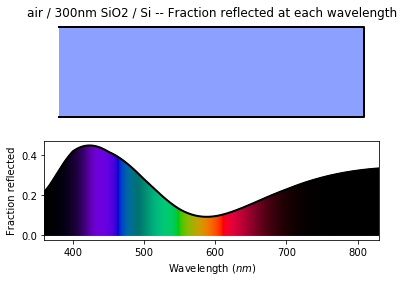

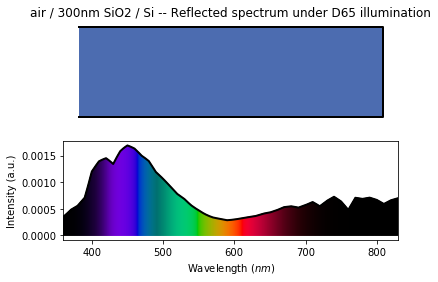

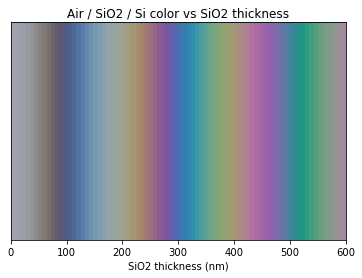

In [4]:
%%time
if not colors_were_imported:
    print('Colorpy was not detected (or perhaps an error occurred when',
          'loading it). You cannot do color calculations, sorry!',
          'http://pypi.python.org/pypi/colorpy')
else:

    # Crystalline silicon refractive index. Data from Palik via
    # http://refractiveindex.info, I haven't checked it, but this is just for
    # demonstration purposes anyway.
    Si_n_data = [[400, 5.57 + 0.387j],
                 [450, 4.67 + 0.145j],
                 [500, 4.30 + 7.28e-2j],
                 [550, 4.08 + 4.06e-2j],
                 [600, 3.95 + 2.57e-2j],
                 [650, 3.85 + 1.64e-2j],
                 [700, 3.78 + 1.26e-2j]]
    Si_n_data = array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    SiO2_n_fn = lambda wavelength : 1.46
    # air refractive index
    air_n_fn = lambda wavelength : 1

    n_fn_list = [air_n_fn, SiO2_n_fn, Si_n_fn]
    th_0 = 0

    # Print the colors, and show plots, for the special case of 300nm-thick SiO2
    d_list = [inf, 300, inf]
    reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
    illuminant = colorpy.illuminants.get_illuminant_D65()
    spectrum = color.calc_spectrum(reflectances, illuminant)
    color_dict = color.calc_color(spectrum)
    print('air / 300nm SiO2 / Si --- rgb =', color_dict['rgb'], ', xyY =', color_dict['xyY'])
    plt.figure()
    color.plot_reflectances(reflectances,
                        title='air / 300nm SiO2 / Si -- '
                              'Fraction reflected at each wavelength')
    plt.figure()
    color.plot_spectrum(spectrum,
                        title='air / 300nm SiO2 / Si -- '
                              'Reflected spectrum under D65 illumination')

    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    max_SiO2_thickness = 600
    SiO2_thickness_list = linspace(0,max_SiO2_thickness,num=80)
    irgb_list = []
    for SiO2_d in SiO2_thickness_list:
        d_list = [inf, SiO2_d, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs SiO2 thickness graph. Compare to (for example)')
    print('http://www.htelabs.com/appnotes/sio2_color_chart_thermal_silicon_dioxide.htm')
    plt.figure()
    plt.plot([0,max_SiO2_thickness],[1,1])
    plt.xlim(0,max_SiO2_thickness)
    plt.ylim(0,1)
    plt.xlabel('SiO2 thickness (nm)')
    plt.yticks([])
    plt.title('Air / SiO2 / Si color vs SiO2 thickness')
    for i in range(len(SiO2_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (SiO2_thickness_list[i] + SiO2_thickness_list[i-1]) / 2
        if i == len(SiO2_thickness_list) - 1:
            x1 = max_SiO2_thickness
        else:
            x1 = (SiO2_thickness_list[i] + SiO2_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)


In [5]:
from pypvcell.transfer_matrix_optics import get_ntotal_fn

air / 300nm SiO2 / Si --- rgb = [ 0.06686505  0.16499302  0.43846789] , xyY = [0.21595883094398391, 0.2135628007669389, 0.16386997003707909]
Saving plot temp_plot.png
Saving plot temp_plot.png
CPU times: user 2.85 s, sys: 46.7 ms, total: 2.89 s
Wall time: 3.01 s


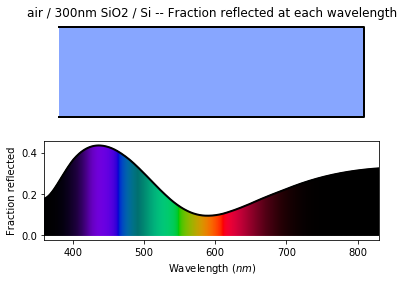

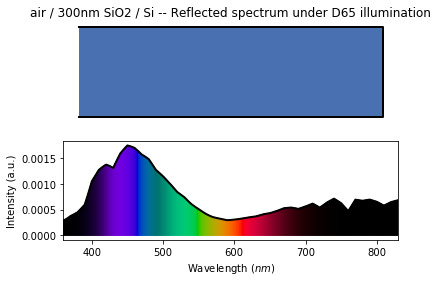

In [6]:
%%time
# Crystalline silicon refractive index. Data from Palik via
# http://refractiveindex.info, I haven't checked it, but this is just for
# demonstration purposes anyway.
Si_n_fn = get_ntotal_fn('a_Si')
# SiO2 refractive index (approximate): 1.46 regardless of wavelength
SiO2_n_fn = get_ntotal_fn('SiO2_2')
# air refractive index
air_n_fn = lambda wavelength : 1

n_fn_list = [air_n_fn, SiO2_n_fn, Si_n_fn]
th_0 = 0

# Print the colors, and show plots, for the special case of 300nm-thick SiO2
d_list = [inf, 300, inf]
reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
illuminant = colorpy.illuminants.get_illuminant_D65()
spectrum = color.calc_spectrum(reflectances, illuminant)
color_dict = color.calc_color(spectrum)
print('air / 300nm SiO2 / Si --- rgb =', color_dict['rgb'], ', xyY =', color_dict['xyY'])
plt.figure()
color.plot_reflectances(reflectances,
                    title='air / 300nm SiO2 / Si -- '
                          'Fraction reflected at each wavelength')
plt.figure()
color.plot_spectrum(spectrum,
                    title='air / 300nm SiO2 / Si -- '
                          'Reflected spectrum under D65 illumination')

Making color vs SiO2 thickness graph. Compare to (for example)
http://www.htelabs.com/appnotes/sio2_color_chart_thermal_silicon_dioxide.htm


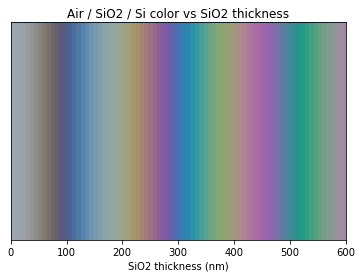

In [7]:
# Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
# integers 0-255) versus thickness of SiO2
max_SiO2_thickness = 600
SiO2_thickness_list = linspace(0,max_SiO2_thickness,num=80)
irgb_list = []
for SiO2_d in SiO2_thickness_list:
    d_list = [inf, SiO2_d, inf]
    reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
    illuminant = colorpy.illuminants.get_illuminant_D65()
    spectrum = color.calc_spectrum(reflectances, illuminant)
    color_dict = color.calc_color(spectrum)
    irgb_list.append(color_dict['irgb'])

# Plot those colors
print('Making color vs SiO2 thickness graph. Compare to (for example)')
print('http://www.htelabs.com/appnotes/sio2_color_chart_thermal_silicon_dioxide.htm')
plt.figure()
plt.plot([0,max_SiO2_thickness],[1,1])
plt.xlim(0,max_SiO2_thickness)
plt.ylim(0,1)
plt.xlabel('SiO2 thickness (nm)')
plt.yticks([])
plt.title('Air / SiO2 / Si color vs SiO2 thickness')
for i in range(len(SiO2_thickness_list)):
    # One strip of each color, centered at x=SiO2_thickness_list[i]
    if i==0:
        x0 = 0
    else:
        x0 = (SiO2_thickness_list[i] + SiO2_thickness_list[i-1]) / 2
    if i == len(SiO2_thickness_list) - 1:
        x1 = max_SiO2_thickness
    else:
        x1 = (SiO2_thickness_list[i] + SiO2_thickness_list[i+1]) / 2
    y0 = 0
    y1 = 1
    poly_x = [x0,  x1,  x1, x0]
    poly_y = [y0, y0, y1, y1]
    color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
    plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

### Plot angular dependent color appearance

Making color vs SiO2 thickness graph. Compare to (for example)
http://www.htelabs.com/appnotes/sio2_color_chart_thermal_silicon_dioxide.htm
CPU times: user 19.2 s, sys: 163 ms, total: 19.4 s
Wall time: 19.9 s


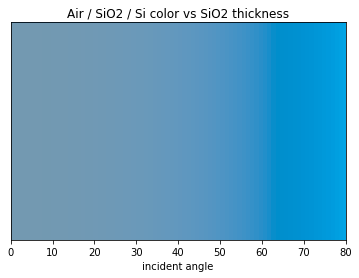

In [8]:
%%time
# Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
# integers 0-255) versus thickness of SiO2
max_inc_angle = 80
inc_angle = linspace(0,max_inc_angle,num=80)
irgb_list = []
SiO2_d=150
for ang in inc_angle:
    d_list = [inf, SiO2_d, inf]
    reflectances = color.calc_reflectances(n_fn_list, d_list, ang/180*pi)
    illuminant = colorpy.illuminants.get_illuminant_D65()
    spectrum = color.calc_spectrum(reflectances, illuminant)
    color_dict = color.calc_color(spectrum)
    irgb_list.append(color_dict['irgb'])

# Plot those colors
print('Making color vs SiO2 thickness graph. Compare to (for example)')
print('http://www.htelabs.com/appnotes/sio2_color_chart_thermal_silicon_dioxide.htm')
plt.figure()
plt.plot([0,max_inc_angle],[1,1])
plt.xlim(0,max_inc_angle)
plt.ylim(0,1)
plt.xlabel('incident angle')
plt.yticks([])
plt.title('Air / SiO2 / Si color vs SiO2 thickness')
for i in range(len(inc_angle)):
    # One strip of each color, centered at x=SiO2_thickness_list[i]
    if i==0:
        x0 = 0
    else:
        x0 = (inc_angle[i] + inc_angle[i-1]) / 2
    if i == len(inc_angle) - 1:
        x1 = max_inc_angle
    else:
        x1 = (inc_angle[i] + inc_angle[i+1]) / 2
    y0 = 0
    y1 = 1
    poly_x = [x0,  x1,  x1, x0]
    poly_y = [y0, y0, y1, y1]
    color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
    plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

Making color vs SiO2 thickness graph. Compare to (for example)
http://www.htelabs.com/appnotes/sio2_color_chart_thermal_silicon_dioxide.htm
CPU times: user 20 s, sys: 287 ms, total: 20.3 s
Wall time: 21.3 s


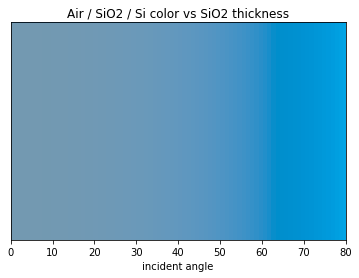

In [9]:
%%time
# Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
# integers 0-255) versus thickness of SiO2
max_inc_angle = 80
inc_angle = linspace(0,max_inc_angle,num=10)
irgb_list = []
SiO2_d=150
for ang in inc_angle:
    d_list = [inf, SiO2_d, inf]
    reflectances = color.calc_reflectances(n_fn_list, d_list, ang/180*pi)
    illuminant = colorpy.illuminants.get_illuminant_D65()
    spectrum = color.calc_spectrum(reflectances, illuminant)
    color_dict = color.calc_color(spectrum)
    irgb_list.append(color_dict['irgb'])

# Plot those colors
print('Making color vs SiO2 thickness graph. Compare to (for example)')
print('http://www.htelabs.com/appnotes/sio2_color_chart_thermal_silicon_dioxide.htm')
plt.figure()
plt.plot([0,max_inc_angle],[1,1])
plt.xlim(0,max_inc_angle)
plt.ylim(0,1)
plt.xlabel('incident angle')
plt.yticks([])
plt.title('Air / SiO2 / Si color vs SiO2 thickness')
for i in range(len(inc_angle)):
    # One strip of each color, centered at x=SiO2_thickness_list[i]
    if i==0:
        x0 = 0
    else:
        x0 = (inc_angle[i] + inc_angle[i-1]) / 2
    if i == len(inc_angle) - 1:
        x1 = max_inc_angle
    else:
        x1 = (inc_angle[i] + inc_angle[i+1]) / 2
    y0 = 0
    y1 = 1
    poly_x = [x0,  x1,  x1, x0]
    poly_y = [y0, y0, y1, y1]
    color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
    plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)